# Model Confidence and Uncertainty Analysis

This notebook analyzes model confidence and uncertainty at patient level
for the Alzheimer's disease classification task.

Predicted probabilities are aggregated per subject (test-time augmentation),
and uncertainty patterns are studied in relation to prediction errors.

# Imports

In [2]:
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, classification_report
from pathlib import Path

# Setup

In [3]:
# Are we running this notebook in colab?
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Personal colab project folder
COLAB_ROOT = Path("/content/drive/MyDrive/Progetti/alzheimer_mri_cnn")

# Ensure working directory is project root
if Path.cwd().parent.name == "alzheimer_mri_cnn":
  os.chdir(Path.cwd().parent)
elif IN_COLAB:
  os.chdir(COLAB_ROOT)
elif Path.cwd().name == "alzheimer_mri_cnn":
  pass
else:
  raise RuntimeError("Project root not found")

print("Working directory set to:", Path.cwd())

# Paths
DB_PATH = Path("./data/processed/oasis.db")
FIGURES_DIR = Path("./outputs/notebooks_figs")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
plt.rcParams["figure.dpi"] = 120

Working directory set to: /content/drive/MyDrive/Progetti/alzheimer_mri_cnn


# Load SQL database

In [10]:
conn = sqlite3.connect(DB_PATH)

query = """
SELECT
    p.patient_id,
    p.label AS true_label,
    pr.prob_ad,
    pr.predicted_label
FROM patients p
JOIN predictions pr USING(patient_id)
"""

df = pd.read_sql_query(query, conn)
conn.close()

df.head()


,patient_id,true_label,prob_ad,predicted_label
0,OAS1_0011_MR1,0,0.005010,0
1,OAS1_0019_MR1,0,0.083759,0
2,OAS1_0028_MR1,1,0.835283,1
3,OAS1_0035_MR1,1,0.833503,1
4,OAS1_0065_MR1,0,0.475843,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       163 non-null    object 
 1   true_label       163 non-null    int64  
 2   prob_ad          163 non-null    float64
 3   predicted_label  163 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 5.2+ KB


In [12]:
df["true_label"].value_counts()

,count
true_label,
0,135
1,28


In [13]:
df["predicted_label"].value_counts()

,count
predicted_label,
0,120
1,43


# Patient metrics

In [14]:
auc = roc_auc_score(df["true_label"], df["prob_ad"])
print(f"Patient-level AUC: {auc:.3f}")

print(classification_report(
    df["true_label"],
    df["predicted_label"],
    digits=3
))


Patient-level AUC: 0.971
              precision    recall  f1-score   support

           0      1.000     0.889     0.941       135
           1      0.651     1.000     0.789        28

    accuracy                          0.908       163
   macro avg      0.826     0.944     0.865       163
weighted avg      0.940     0.908     0.915       163



# Probability distribution

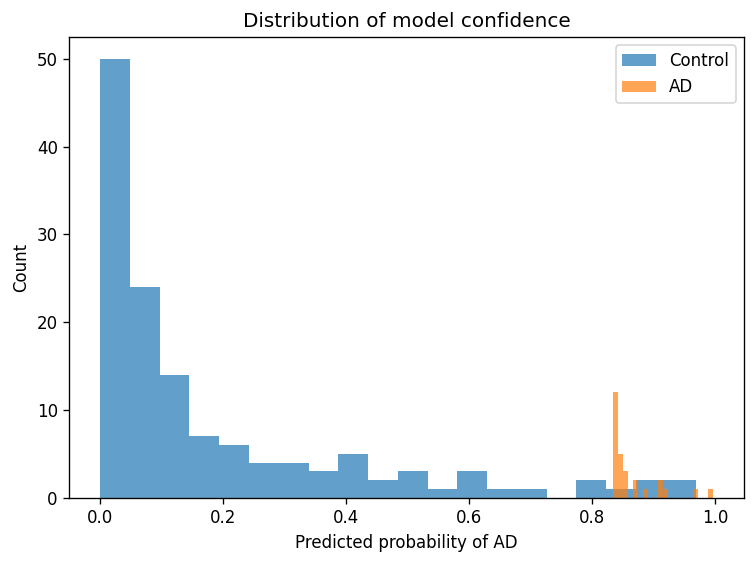

In [15]:
plt.figure()
plt.hist(
    df[df.true_label == 0]["prob_ad"],
    bins=20,
    alpha=0.7,
    label="Control"
)
plt.hist(
    df[df.true_label == 1]["prob_ad"],
    bins=20,
    alpha=0.7,
    label="AD"
)

plt.xlabel("Predicted probability of AD")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of model confidence")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "model_confidence.png")
plt.show()


# Uncertainty

We define uncertainty as ∣p(AD)−0.5∣. If p(AD)=1 then there's a very high chance of AD and uncertainty is 0.5. Similarly if p(AD)=0 with very low chance of AD. If p(AD)=0.5 then uncertainty is 0 meaning we can't differentiate between the 2 classes.

In [17]:
df["uncertainty"] = np.abs(df["prob_ad"] - 0.5)

df.head()


,patient_id,true_label,prob_ad,predicted_label,uncertainty
0,OAS1_0011_MR1,0,0.005010,0,0.494990
1,OAS1_0019_MR1,0,0.083759,0,0.416241
2,OAS1_0028_MR1,1,0.835283,1,0.335283
3,OAS1_0035_MR1,1,0.833503,1,0.333503
4,OAS1_0065_MR1,0,0.475843,0,0.024157


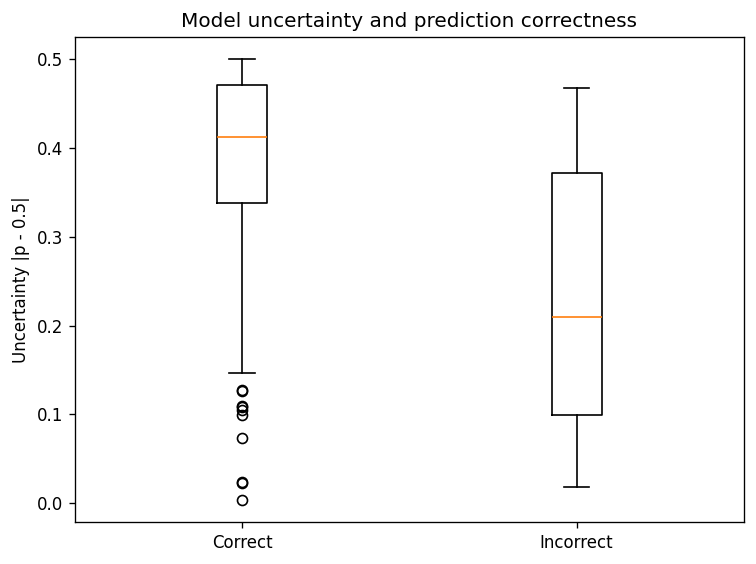

In [21]:
df["correct"] = (df["true_label"] == df["predicted_label"]).astype(int)
plt.figure()
plt.boxplot(
    [
        df[df.correct == 1]["uncertainty"],
        df[df.correct == 0]["uncertainty"]
    ],
    tick_labels=["Correct", "Incorrect"]
)
plt.ylabel("Uncertainty |p - 0.5|")
plt.title("Model uncertainty and prediction correctness")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "model_uncertainty_correctness.png")
plt.show()


In [22]:
high_uncertainty = df.sort_values("uncertainty").head(10)
high_uncertainty

,patient_id,true_label,prob_ad,predicted_label,uncertainty,correct
71,OAS1_0113_MR1,0,0.496564,0,0.003436,1
51,OAS1_0221_MR1,0,0.518897,1,0.018897,0
12,OAS1_0116_MR1,0,0.476667,0,0.023333,1
4,OAS1_0065_MR1,0,0.475843,0,0.024157,1
74,OAS1_0135_MR1,0,0.527156,1,0.027156,0
81,OAS1_0212_MR1,0,0.533758,1,0.033758,0
13,OAS1_0138_MR1,0,0.426967,0,0.073033,1
33,OAS1_0013_MR1,0,0.585296,1,0.085296,0
59,OAS1_0301_MR1,0,0.401078,0,0.098922,1
34,OAS1_0032_MR1,0,0.395138,0,0.104862,1


# False positives and negatives

In [23]:
false_pos = df[(df.true_label == 0) & (df.predicted_label == 1)]
false_neg = df[(df.true_label == 1) & (df.predicted_label == 0)]

len(false_pos), len(false_neg)

(15, 0)

In [24]:
false_pos[["patient_id", "prob_ad"]].head()

,patient_id,prob_ad
33,OAS1_0013_MR1,0.585296
42,OAS1_0110_MR1,0.918720
51,OAS1_0221_MR1,0.518897
61,OAS1_0338_MR1,0.612564
62,OAS1_0354_MR1,0.709367


In [25]:
false_neg[["patient_id", "prob_ad"]].head()

,patient_id,prob_ad


## Summary

This analysis highlights how model uncertainty relates to prediction errors.
Misclassified subjects tend to exhibit lower confidence scores, suggesting
that uncertainty estimates may be useful for identifying ambiguous cases.